In [1]:
import numpy as np
import pandas as pd

from matplotlib.pylab import rcParams
import matplotlib.pylab as plt 

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore')#, category=FutureWarning)

In [2]:
file = pd.read_csv("samples_cu02.csv")
file.columns = ['Time', 'ECG']                     ## renames column objects
data = file[1:]                                    ## gets rid of string format
data['Time'] = data['Time'].str.replace("'", "")   ## cleans out '' from data

data.Time = pd.to_datetime(data.Time, format = '%M:%S.%f')
data.Time = data['Time'].dt.strftime('%S.%f')      ## gets rid of yyyy-mm-dd
data['Time'] = data['Time'].astype(float)          ## convert it to numbers for plotting

data['ECG'] = data['ECG'].astype(float)            ## convert it to numbers for plotting

In [3]:
#Resizes the graphs
plt.rcParams['figure.figsize'] = (20,12)

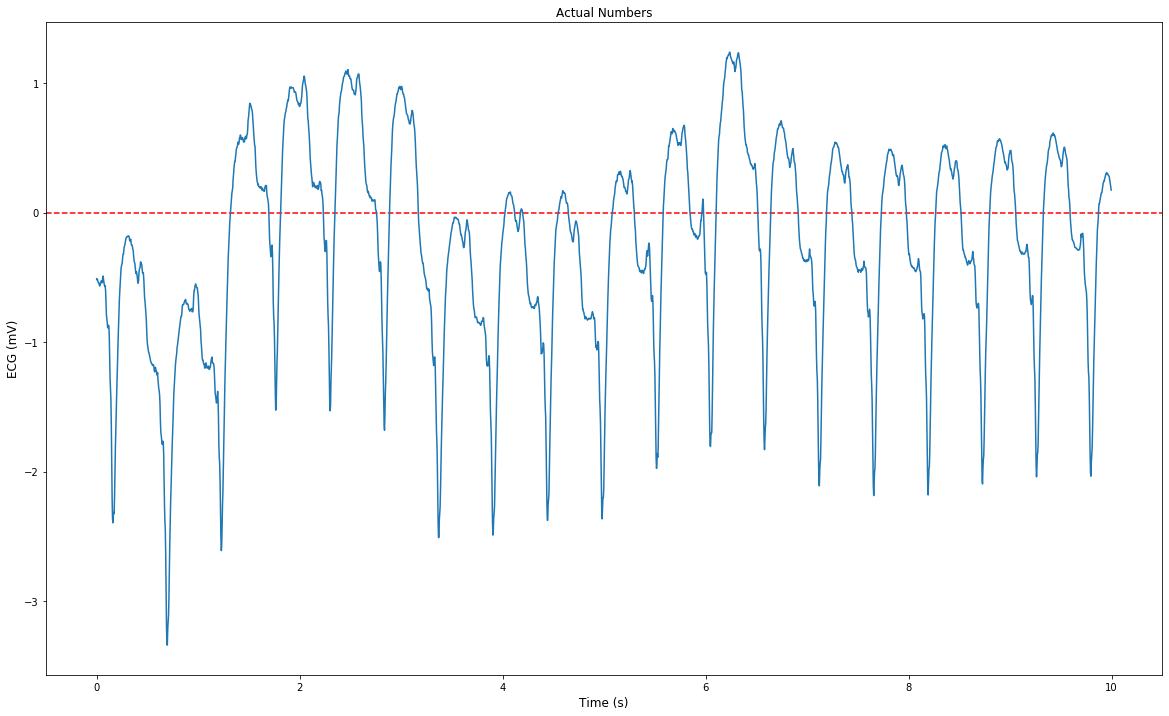

In [4]:
#plot original raw ECG dataset
plt.title('Actual Numbers', fontsize = 12)
plt.xlabel("Time (s)", fontsize = 12)
plt.ylabel("ECG (mV)", fontsize = 12)

plt.axhline(y=0, linestyle='--', color='red')

plt.plot(data.Time, data.ECG)

In [5]:
#Function checks for Stationarity
from statsmodels.tsa.stattools import adfuller
dataECG = data.ECG

def stationarity(data):
    
    #Determine + Plot rolling statistic
    movingAVG = data.rolling(window=400).mean()
    movingSTD = data.rolling(window=400).std()

    plt.xlabel('Data Points')
    #plt.xticks(rotation=60)
    plt.ylabel("ECG mV")
    orig = plt.plot(data, color = 'blue', label='Original')
    mean = plt.plot(movingAVG, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='green', label='Rolling Std')
    plt.axhline(y=1, linestyle='--', color='gray')
    plt.axhline(y=0, linestyle='--', color='gray')
    plt.axhline(y=-1, linestyle='--', color='gray')
    plt.legend(loc='upper left', fontsize = 16)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(data, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index= ['Test Statistic', 'p-value', '#Lags Used', 'Total #Points'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

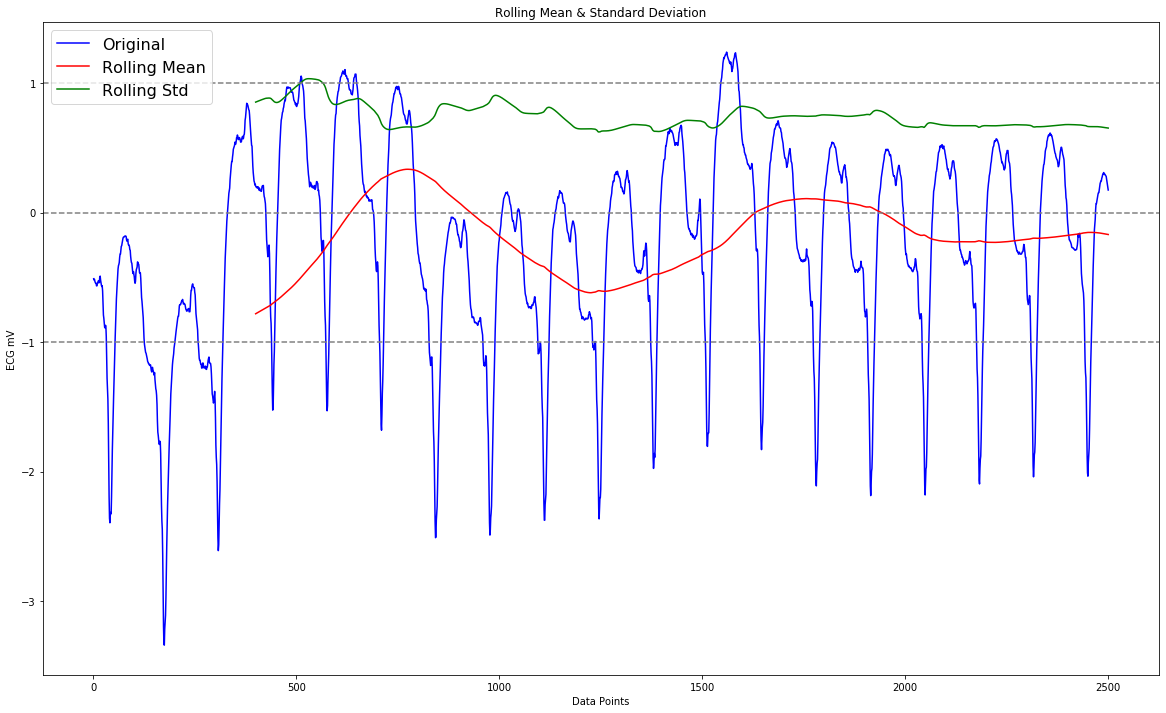

Results of Dickey-Fuller Test:
Test Statistic         -5.822134e+00
p-value                 4.159188e-07
#Lags Used              2.600000e+01
Total #Points           2.473000e+03
Critical Value (1%)    -3.432997e+00
Critical Value (5%)    -2.862709e+00
Critical Value (10%)   -2.567393e+00
dtype: float64


In [6]:
#check for trend and seasonality
stationarity (dataECG) #not stationary

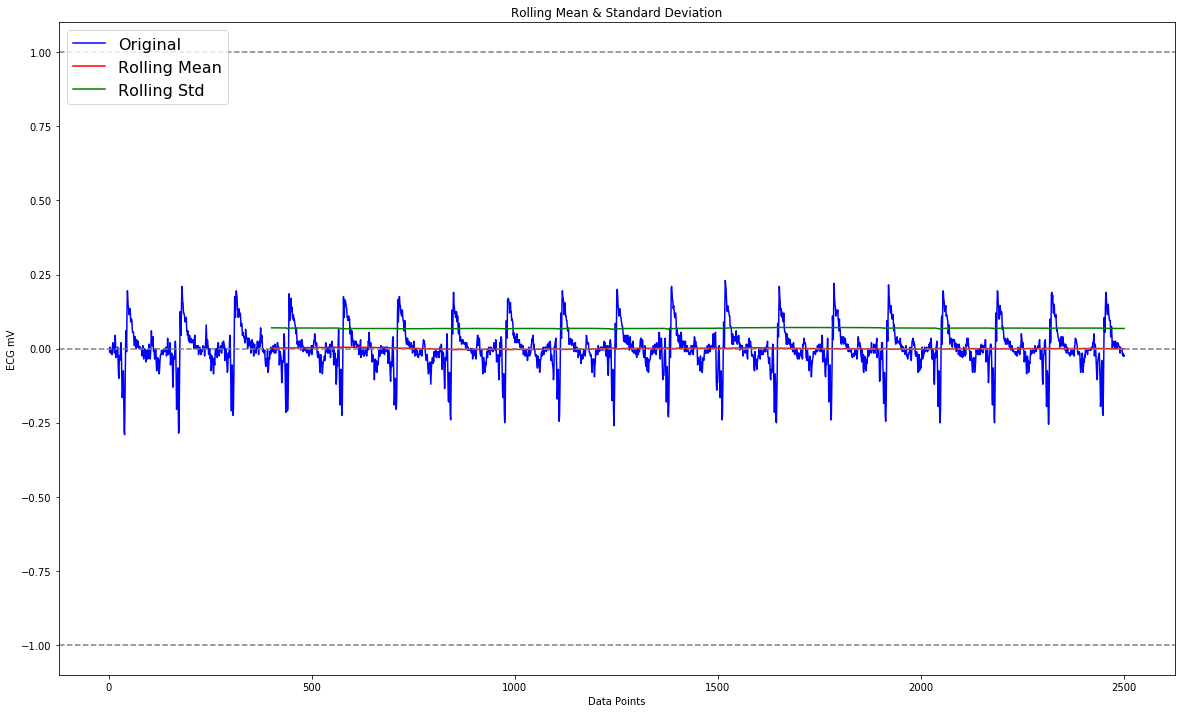

Results of Dickey-Fuller Test:
Test Statistic         -1.067112e+01
p-value                 4.164673e-19
#Lags Used              2.700000e+01
Total #Points           2.471000e+03
Critical Value (1%)    -3.432999e+00
Critical Value (5%)    -2.862710e+00
Critical Value (10%)   -2.567393e+00
dtype: float64


In [7]:
#differentiate the data to remove trend
dataD1 = dataECG - dataECG.shift() 
dataD1.dropna(inplace=True)

stationarity (dataD1) #Stationary, d=1

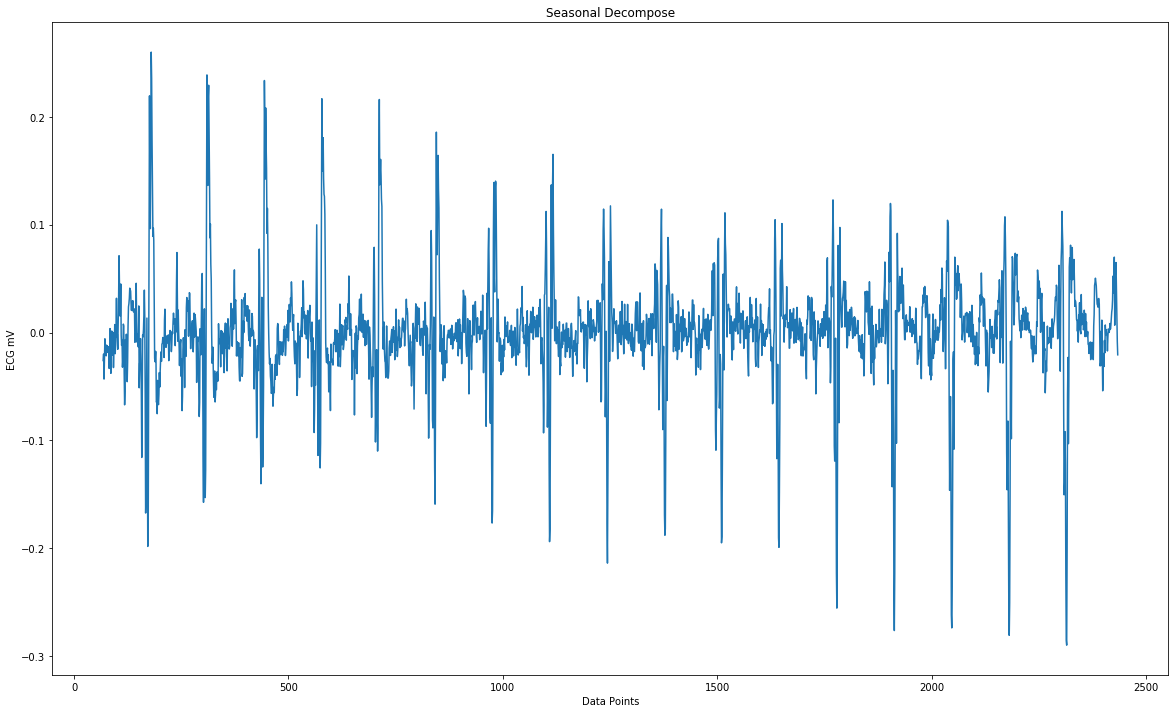

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose (dataD1, model= 'additive', freq = 133)

plt.title('Seasonal Decompose')
plt.xlabel('Data Points')
plt.ylabel('ECG mV')
plt.plot(result.resid)

In [9]:
#diff = list()
#cycle = 133

#for i in range(cycle, len(dataD1)):
#    value = dataD1[i] - dataD1[i - cycle]
#    diff.append(value)
    
#plt.plot(diff)
#plt.show()

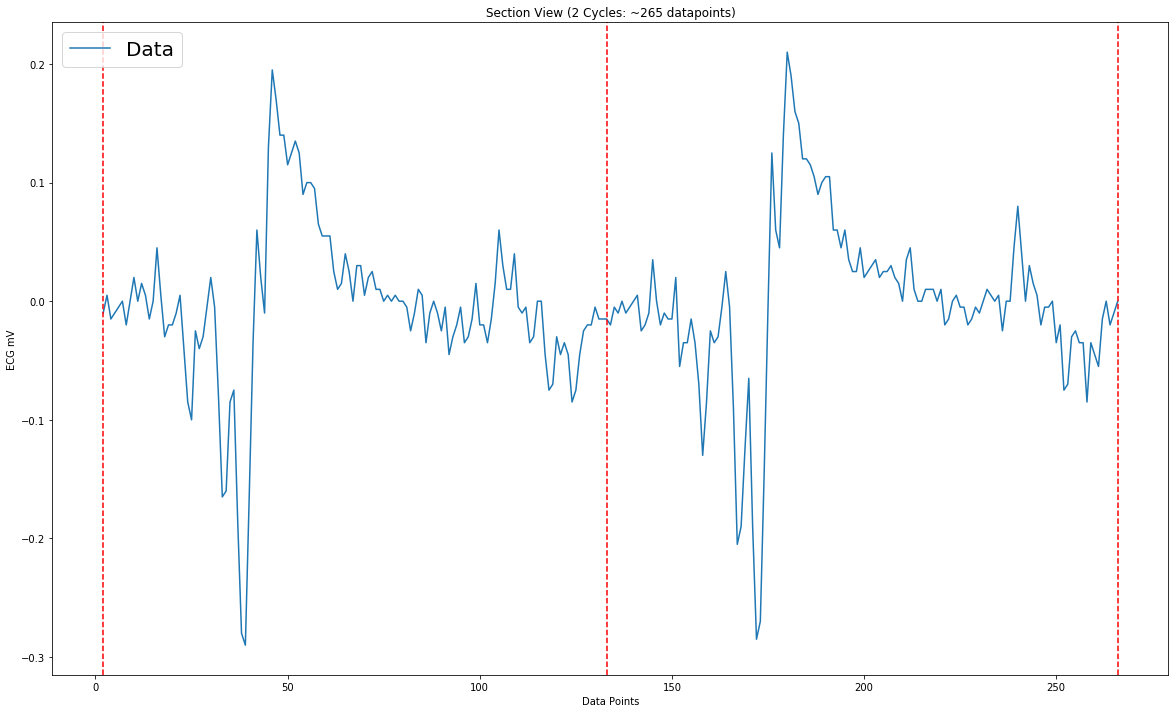

In [10]:
plt.plot(dataD1[:265], label= 'Data') # about two full periods, originally :265
plt.axvline(x=2, linestyle='--', color='red')
plt.axvline(x=266, linestyle='--', color='red')
plt.axvline(x=133, linestyle='--', color='red') #first interval

plt.title('Section View (2 Cycles: ~265 datapoints)')
plt.xlabel('Data Points')
plt.ylabel('ECG mV')
plt.legend(loc='upper left', fontsize = 20)
plt.show()

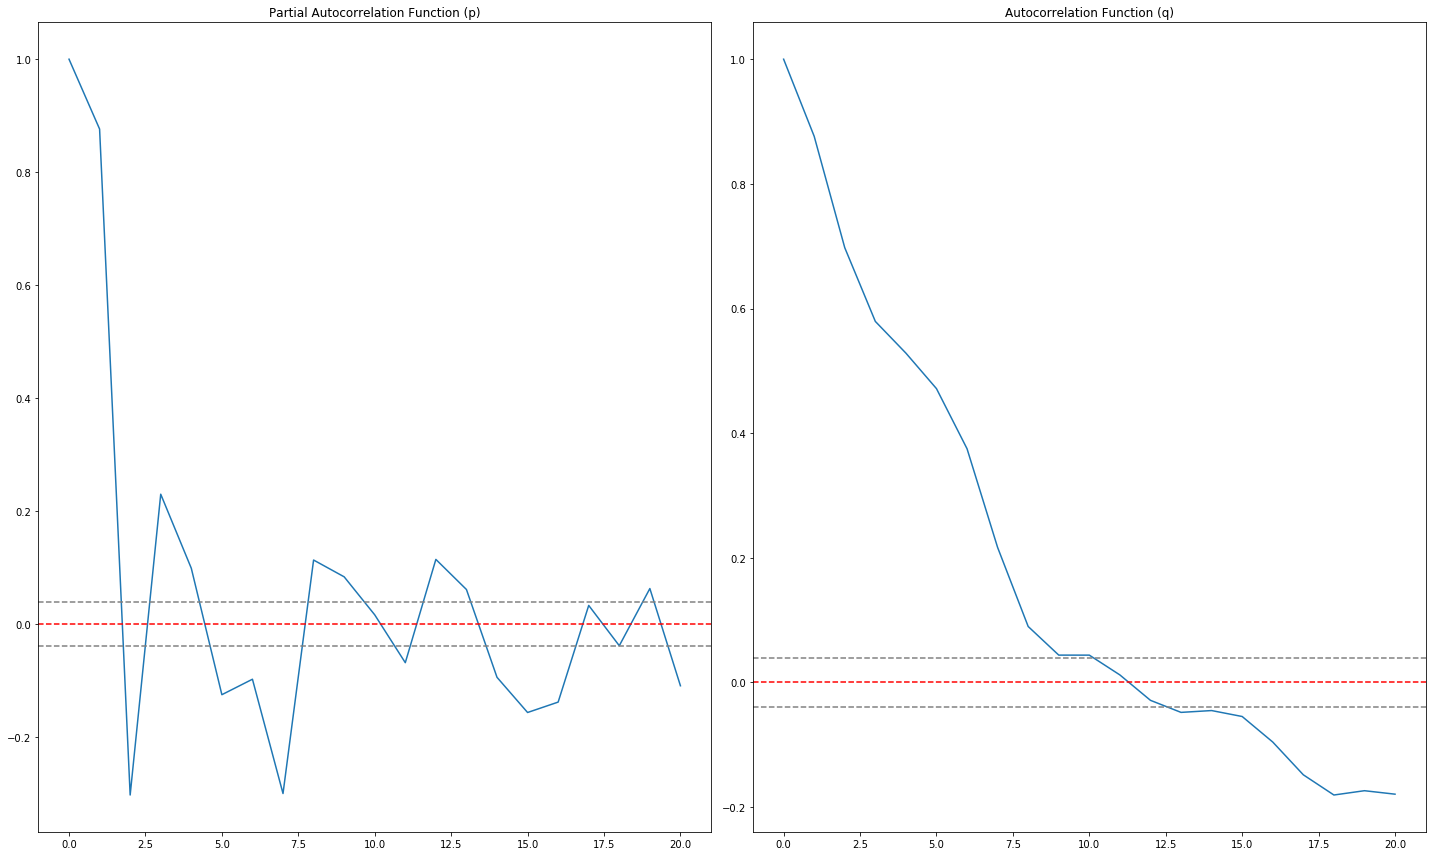

In [11]:
from statsmodels.tsa.stattools import acf, pacf

#PACF(calculate p, AR) and ACF (calculate q, MA)plots:
lag_acf = acf(dataD1, nlags = 20)        ## 'ols' is ordinary least square method
lag_pacf = pacf(dataD1, nlags = 20, method= 'ols')

## p and q where the graph is first y=0
#Plot PACF:
plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color ='red')
plt.axhline(y=-1.96/np.sqrt(len(dataD1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataD1)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (p)') #p=2

#Plot ACF:
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(dataD1)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(dataD1)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (q)') #### p=2, need further check ########################################################
plt.tight_layout()

In [12]:
from statsmodels.tsa.arima_model import ARIMA

def predict (train, index, iteration):

    model = ARIMA(train, order=(2,1,2))#.fit(start_params=init)
    fitted = model.fit(disp=-1)

    #Forecast
    fc, se, conf = fitted.forecast(iteration, alpha= 0.05)
    forecast = pd.Series(fc, index.index)

    return forecast

In [13]:
import warnings
warnings.filterwarnings("ignore")

#split differentiated dataset in half
dataFirst = dataD1.iloc[:1249]
dataLast = dataD1.iloc[1249:]

training = dataFirst   #training and updating
dataset1 = dataLast    #used to run the model
dataset2 = dataLast    #used to compare

#set range for forecast loop
length = len(dataset1) + 1
testing = range(length, 2501)

In [14]:
#partial forecast loop
x = 1 #counter

print('                   Forecasting                    ')
for i in testing:
    
    print("|", end = '') #indicate each iteration
    
    #every 50 iterations display percentile progress
    if x%50 == 0:
        print(" ~  " + '{:02.0f}'.format(4 * (x/50)) + "%")
        
    #set forecast to predict if odd and actual of even
    if i%2 == 1:
        forecast = predict (training, dataset1[:1], 1)   
    else:
        forecast = dataset1.iloc[:1]
    
    #append forcast to update training
    training = training.append(forecast)
    dataset1 = dataset1.iloc[1:]
    x = x + 1 #increment x for the iteration
    
print ('++++++++++++++++++++++++++++++++++++++++++++++++++ ~  Numbers Ready')

                   Forecasting                    
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  04%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  08%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  12%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  16%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  20%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  24%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  28%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  32%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  36%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  40%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  44%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  48%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  52%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  56%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  60%
|||||||||||||||||||||||||||||||||||||||||||||||||| ~  64%
|||||||||||||||||||||

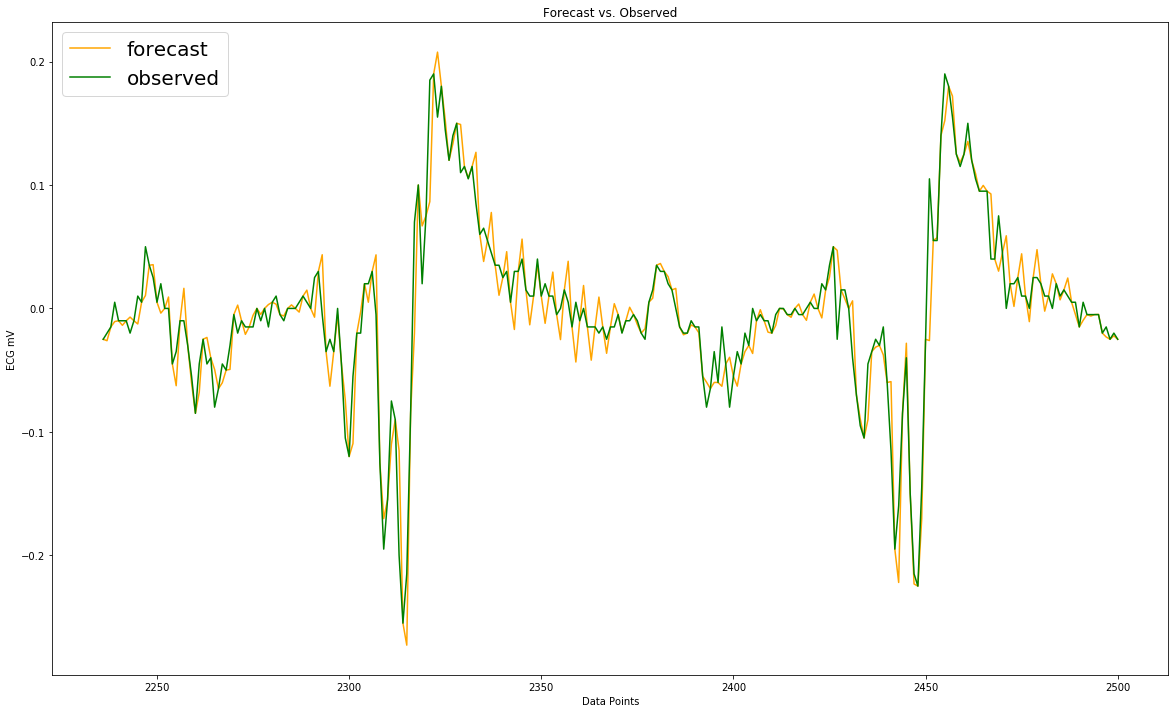

In [42]:
#plots the last 265 data points for visibility
#265 is about two full periods of patterning

forecastSet = training.iloc[2234:] #training has total of 2500 pts, 2500 - 265
originalSet = dataset2.iloc[985:]  #dataset2 has total of 1250 pts, 1250 - 265

#plt.plot(trainingSet, label= 'training', color='black')
plt.plot(forecastSet, label= 'forecast', color='orange')
plt.plot(originalSet, label= 'observed', color='green')

plt.title('Forecast vs. Observed')
plt.xlabel('Data Points')
plt.ylabel('ECG mV')
plt.legend(loc='upper left', fontsize = 20)
plt.show()

In [58]:
testing2 = range(2236,2501) #local error check 265 points
localErrorList= []

total = 0
for i in testing2:
    if i%2 == 1:
        localError = abs(forecastSet[i]-originalSet[i])
    else:
        localError = 0.0
    
    localErrorList.insert(i, localError)
    total = total + localError

localErrorSeries = pd.Series(localErrorList, index = testing2)
avgLocalError = total/133 
print ('Average of ' + '{:0.4f}'.format(avgLocalError) + ' Local Error Distance')


Average of 0.0228 Local Error Distance


In [59]:
forecastD2 = training.iloc[1249:] #training has total of 2500 pts, 2500 - 1250
originalD2 = dataset2  #dataset2 has total of 1250 pts, 1250 

In [61]:
testing3 = range(1251,2501) #total forecast error check 1250 points check
errorList= []

total = 0
for i in testing3:
    if i%2 == 1:
        error = abs(forecastD2[i]-originalD2[i])
    else:
        error = 0.0
    
    errorList.insert(i, error)
    total = total + error

errorSeries = pd.Series(localErrorList, index = testing2)
avgError = total/1250
print ('Average of ' + '{:0.4f}'.format(avgLocalError) + ' Total Error Distance')

print('Error Check Complete')

Average of 0.0228 Total Error Distance
Error Check Complete


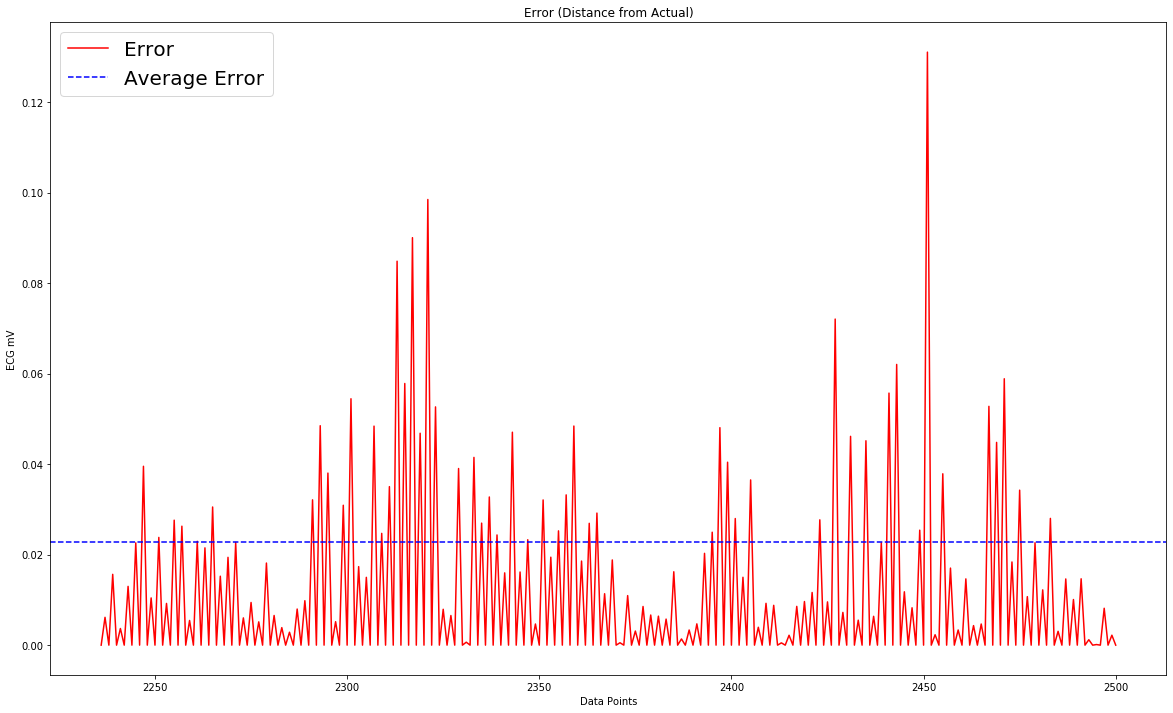

In [36]:
listRange = list(range(2236, 2501))

plt.plot (listRange, localErrorList, color ='red', label='Error')
plt.axhline(y=avgLocalError, linestyle='--', color='blue', label='Local Average')

plt.title('Error (Distance from Actual)')
plt.xlabel('Data Points')
plt.ylabel('ECG mV')
plt.legend(loc='upper left', fontsize = 20)
plt.show()

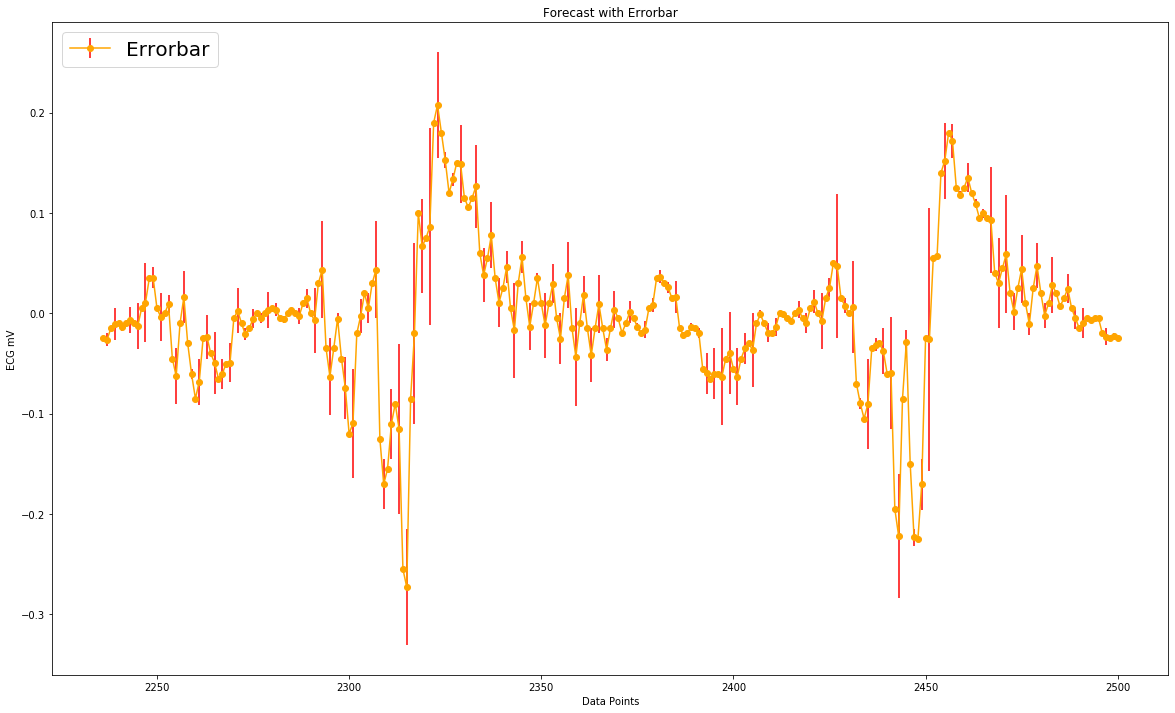

In [38]:
plt.errorbar(testing2, forecastSet, localErrorSeries, ecolor = 'red', color = 'orange', label= 'Errorbar', marker= 'o')

plt.title('Forecast with Errorbar')
plt.xlabel('Data Points')
plt.ylabel('ECG mV')
plt.legend(loc='upper left', fontsize = 20)
plt.show()